
# The incompressible Navier-Stokes equations with IPCS

Please have a look at the separate *navierstokes-intro* file for explanations.

At your choice you may replace the IPCS splitting scheme by another
splitting scheme of your choice. However, this has an impact on the
boundary conditions that can be applied. In particular, the
Peaceman-Racheford scheme does not allow you to impose boundary
conditions for the pressure.

# Task A

Implement the Incremental Pressure Correction Scheme (IPCS) desribed
in the Navier-Stokes intro by expressing the variational
formulations in UFL. Use a Taylor-Hood finite element type to
discretize, e.g.:

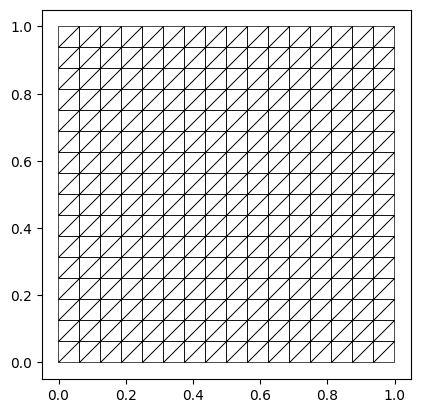

In [1]:

from dune.grid import cartesianDomain
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.space import lagrange
import dune
from dune import fem
import numpy as np
import ufl

domain = cartesianDomain([0,0], [1,1], [16,16])
gridView = leafGridView(domain)
order = 2

# velocity space (vector valued)
V_space = lagrange(gridView, order=order, dimRange=gridView.dimension) # p1Bubble als alternative
# pressure space
P_space = lagrange(gridView, order=order-1)
compositeTaylorHoodSpace = fem.space.composite(V_space, P_space, components=["velocity", "pressure"])
mu  = dune.ufl.Constant(1, "mu")
rho = dune.ufl.Constant(1, "rho")
dt = dune.ufl.Constant(0.1, "dt")

U = ufl.TrialFunction(compositeTaylorHoodSpace)
V = ufl.TestFunction(compositeTaylorHoodSpace)
x = ufl.SpatialCoordinate(compositeTaylorHoodSpace)
n = ufl.FacetNormal(compositeTaylorHoodSpace)
u = ufl.as_vector([U[0], U[1]])
v = ufl.as_vector([V[0], V[1]])
p = U[gridView.dimension]
q = V[gridView.dimension]
no_slip_bottom = dune.ufl.DirichletBC(compositeTaylorHoodSpace, [0,0,None], x[1] < 1e-10)
no_slip_top = dune.ufl.DirichletBC(compositeTaylorHoodSpace, [0,0,None], x[1] > 1-1e-10)
pressure_dirichlet = dune.ufl.DirichletBC(compositeTaylorHoodSpace, [None, None, 8-x[0]*8])
f = ufl.as_vector([0, 0])
gridView.plot()
u_solution = V_space.function(name="u_solution")
p_solution = P_space.function(name="p_solution")
u_old = V_space.function(name="u_old")


In [7]:
epsilon = lambda w:  1/2*(ufl.nabla_grad(w) + ufl.nabla_grad(w).T)
sigma = -p*ufl.Identity(gridView.dimension) + 2*mu*epsilon(u)

velocity_neumann_form = mu * ufl.inner(ufl.dot(ufl.grad(u), n) - p*n, v)*ufl.ds
step_one_form = rho*ufl.inner((u - u_old)/dt, v)*ufl.dx 
+ ufl.inner(sigma, epsilon(v))*ufl.dx 
- rho * ufl.inner(ufl.inner(u_old,ufl.nabla_grad(u)), v)*ufl.dx
step_one_form -= velocity_neumann_form * (ufl.conditional(ufl.lt(x[1], 1e-10), 1, 0) + ufl.conditional(ufl.gt(x[1], 1-1e-10), 1, 0))

Shapes do not match: <Coefficient id=139791089103232> and <NablaGrad id=139791087577280>.


DUNE-ERROR: Shapes do not match: <Coefficient id=139791089103232> and <NablaGrad id=139791087577280>.


UFLException: Shapes do not match: <Coefficient id=139791089103232> and <NablaGrad id=139791087577280>.

time step by solving __Step 1__, __Step 2__, and then __Step
3__. Test your implementation using the Poiseuille flow problem.

## Poiseuille flow

Let $\Omega = [0,L] \times [0,H] \subset \mathbb{R}^2$ be the
computational domain where $H$ is the distance of two plates from
each other and $L$ the length of the channel. Define the boundaries
as

\begin{align*}
\Gamma_{left}   &= 0 \times [0,H],\\
\Gamma_{right}  &= L \times [0,H],  \\
\Gamma_{top}    &= [0,L] \times H,  \\
\Gamma_{bottom} &= [0,L] \times 0.
\end{align*}

Solve the Navier-Stokes equations (1-2) with $\mu = 1$, $\rho = 1$,
and $f=0$ for the following initial conditions:

$$
u(0,x) = 0 \quad \forall x \in \Omega
$$
and boundary conditions
$$
u(t,x) = 0 \quad \forall x \in \Gamma_{top} \cup \Gamma_{bottom}.
$$

In order to be able to solve Poisson's equation for the pressure in
sub-step 2 you may for simplicity just impose Dirichlet conditions for the pressure though this in general is not feasible:

\begin{align*}
p(t,x) &= 8 \quad \forall x \in \Gamma_{left},\\
p(t,x) &= 0 \quad \forall x \in \Gamma_{right}.
\end{align*}

In order for this to work you have to impose Neumann boundary
conditions on the velocity, as detailed in the `navierstokes-intro`
slides, i.e. an appropriate boundary integral has to be added to the
equation of step 1.

Run the simulation until $T=10$ and use a time step size small
enough, e.g. $\triangle t = 0.02$ with the above $16$ cells in each
direction.

A steady state solution to this problem is given by $u(x) =
4x_2(1−x_2)$ and $p(x)=8(1 - x_1)$ with $x = (x_1,x_2) \in
\mathbb{R}^2$. Compare your numerical results to the exact solution
and compute the $L_2$ error between your computed solution and the
steady state solution. At which time $t \in (0,T]$ is the steady
state reached? Discuss the impact of mesh refinement on the
difference between the discrete steady state and the exact steady
state.

# Task B

Repeat the problem from __Task A__ with an unstructured grid.
Create a triangular grid with __pygmsh__, and integrate that into your code.

In [ ]:

import pygmsh
with pygmsh.occ.Geometry() as geom:
    # add rectangle with length 1 in x and 1 in y direction.
    L, H = 1. , 1.
    rectangle = geom.add_rectangle([0,0,0], L, H)
    mesh = geom.generate_mesh()
    points, cells = mesh.points, mesh.cells_dict
    # convert to dictionary understood by DUNE
    domain = {"vertices": points[:,:2].astype(float),
              "simplices": cells["triangle"].astype(int)}
    print("Number of elements: ", len(domain["simplices"]))

gridView = leafGridView(domain, dimgrid=2)
gridView.plot()

# Task C

Flow around a cylinder: __Karman Vortex Street__.

Consider the domain $\Omega = [0,L] \times [0,H] \setminus B_r(0.2,
0.2) \subset \mathbb{R}^2$ with $L=2.2$, $H=0.41$ and
$r=0.05$. Define the boundaries as

\begin{align*}
\Gamma_{left}   &= 0 \times [0,H],\\
\Gamma_{right}  &= L \times [0,H],  \\
\Gamma_{top}    &= [0,L] \times H,  \\
\Gamma_{bottom} &= [0,L] \times 0.
\end{align*}

Solve the Navier-Stokes equations (1-2) with $\mu = 10^{-3}$, $\rho
= 1$, and $f=0$. Use the following boundary condition on the
"unproblematic" lower, upper and right boundaries:
\begin{align*}
u(t,x) &= 0 \quad \forall x \in \Gamma_{top} \cup \Gamma_{bottom} \cup \partial B_r,\\
\partial_n u(t,x) &= 0 \quad \forall x \in \Gamma_{right},
p(t,x) &= 0 \quad \forall x \in \Gamma_{right}.
\end{align*}

Note that the Navier-Stokes equation in principle do not allow to
impose boundary values for the pressure. Nevertheless
pressure-correction schemes are quite popular because they are
computationally very performant. Of course, if one would know that

For the initial conditions and the conditions on the inflow boundary
$\Gamma_{left}$ one has to be careful. When imposing non-zero inflow
right from the start then an initial value $u=0$ is incompatible
with the inflow condition on $\Gamma_{left}$. There are at least two
possible ways to cope with this:

- gradually increase the inflow profile: use the initial condition
$$
u(0,x) = 0 \quad \forall x \in \Omega
$$
but only gradually increase the inflow starting from zero up the the target inflow profile
$$
u(t,x) = \left( \frac{6 x_2(H−x_2)}{H^2}, 0 \right) \quad \forall x \in \Gamma_{left}
$$

- numerically compute compatible initial values: start witht the
target inflow profile right from time $0$ and use an initial value
which is the solution of the stationary stokes equation which
satisfies all boundary conditions for $u$, including the non-zero
inflow profile. For this you can, e.g., use the Uzawa algorithm for
the (Quasi-)Stokes problem that you have implemented in the second
week of the course (or use the corresponding Python code from the
ILIAS page).

Create an appropriate grid using __pygmsh__ and run the simulation
until $T=5$ and use a time step size small enough, e.g. $\triangle t
= T / 10^5$. This number depends on the grid size of your mesh
(i.e. the smallest edge length present).

A sketch of the domain and a picture of expected results can be
found
[here](https://www.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html).
Please note that the DFG-benchmark problem uses a different
formulation of the Navier-Stokes equations where the Neumann
boundary conditions on the free boundary for the velocity $u$ are
just "natural" i.e. the boundary integral resulting from integration
by parts is just left out in the weak formulation.

Note: please have a look at the folder "Tools and Examples" of the
ILIAS page for the course; in particular for example code concerning
the construction of the computational domain.

# Task D

Test different preconditioning options available and report the observed results.

__Note__: Not all preconditioning methods work with parallelization. For parallel tests use the PETSc options.

Please use at least three different preconditioners. "observed results"
should include the number of iterations needed to solve the
sub-problems as well as the actual time needed to carry out the simulation.

## Task E -- Parallel implementation

Adjust your program such that it can run in parallel using MPI,
e.g. on $4$ cores (or use more, but at least more than $1$ core!) using

```
mpirun -np 4 python your_program.py
```

Please keep in mind that on your laptop parallelization may gain
little to no speedup. You will be given access to a compute-server
of the Maths department. Run speed-up tests on that server. For
meaningful results you have to control the number of threads used
for linear algebra, e.g.


In [ ]:
from dune.fem import threading
threading.use = 1
#

## Task F -- Adaptivity

Run the Karman Vortex Street example using adaptive mesh refinement
and coarsening. As an indicator use the curl of $u$ also known as
the vorticity. More precise: use the $L^2$-norm of the curl on each
element. Refine the grid, where the vorticity is high, and coarsen,
where the vorticity is low.

Consult the tutorial for the appropriate adaptivity cycle, in
particular the solution-code for the Cahn-Hilliard and Heat-Robin
examples. Both can be found in the ILIAS.
